In [21]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [22]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(224),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# data_dir = 'data/hymenoptera_data'
data_dir = 'data/vespa'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

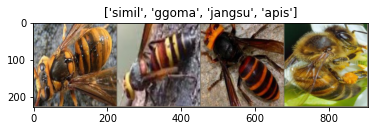

In [23]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [24]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [25]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            print(preds)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [26]:
# model_ft = models.resnet18(pretrained=True)
# model_ft = models.resnet18(weights='ResNet18_Weights.DEFAULT')
model_ft = models.resnet152(weights='ResNet152_Weights.DEFAULT')


num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to C:\Users\CILAB/.cache\torch\hub\checkpoints\resnet152-f82ba261.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [27]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=300)

Epoch 0/299
----------
train Loss: 0.6176 Acc: 0.7822
val Loss: 0.1922 Acc: 0.9389

Epoch 1/299
----------
train Loss: 0.1769 Acc: 0.9450
val Loss: 0.1390 Acc: 0.9589

Epoch 2/299
----------
train Loss: 0.1020 Acc: 0.9713
val Loss: 0.1135 Acc: 0.9711

Epoch 3/299
----------
train Loss: 0.0628 Acc: 0.9819
val Loss: 0.1205 Acc: 0.9656

Epoch 4/299
----------
train Loss: 0.0413 Acc: 0.9891
val Loss: 0.1147 Acc: 0.9600

Epoch 5/299
----------
train Loss: 0.0380 Acc: 0.9893
val Loss: 0.1215 Acc: 0.9633

Epoch 6/299
----------
train Loss: 0.0302 Acc: 0.9912
val Loss: 0.0942 Acc: 0.9678

Epoch 7/299
----------
train Loss: 0.0152 Acc: 0.9970
val Loss: 0.0927 Acc: 0.9700

Epoch 8/299
----------
train Loss: 0.0152 Acc: 0.9954
val Loss: 0.0951 Acc: 0.9711

Epoch 9/299
----------
train Loss: 0.0145 Acc: 0.9965
val Loss: 0.0907 Acc: 0.9711

Epoch 10/299
----------
train Loss: 0.0110 Acc: 0.9974
val Loss: 0.0978 Acc: 0.9689

Epoch 11/299
----------
train Loss: 0.0100 Acc: 0.9975
val Loss: 0.0934 Acc

val Loss: 0.0958 Acc: 0.9744

Epoch 97/299
----------
train Loss: 0.0071 Acc: 0.9982
val Loss: 0.0994 Acc: 0.9744

Epoch 98/299
----------
train Loss: 0.0075 Acc: 0.9982
val Loss: 0.0880 Acc: 0.9744

Epoch 99/299
----------
train Loss: 0.0081 Acc: 0.9982
val Loss: 0.0924 Acc: 0.9744

Epoch 100/299
----------
train Loss: 0.0077 Acc: 0.9981
val Loss: 0.0807 Acc: 0.9756

Epoch 101/299
----------
train Loss: 0.0085 Acc: 0.9982
val Loss: 0.0988 Acc: 0.9678

Epoch 102/299
----------
train Loss: 0.0085 Acc: 0.9982
val Loss: 0.0907 Acc: 0.9756

Epoch 103/299
----------
train Loss: 0.0077 Acc: 0.9982
val Loss: 0.0977 Acc: 0.9700

Epoch 104/299
----------
train Loss: 0.0074 Acc: 0.9979
val Loss: 0.0904 Acc: 0.9744

Epoch 105/299
----------
train Loss: 0.0076 Acc: 0.9984
val Loss: 0.0918 Acc: 0.9711

Epoch 106/299
----------
train Loss: 0.0075 Acc: 0.9981
val Loss: 0.0996 Acc: 0.9678

Epoch 107/299
----------
train Loss: 0.0076 Acc: 0.9982
val Loss: 0.0903 Acc: 0.9722

Epoch 108/299
----------
tr

train Loss: 0.0102 Acc: 0.9965
val Loss: 0.0893 Acc: 0.9733

Epoch 193/299
----------
train Loss: 0.0084 Acc: 0.9984
val Loss: 0.1018 Acc: 0.9756

Epoch 194/299
----------
train Loss: 0.0077 Acc: 0.9984
val Loss: 0.0951 Acc: 0.9733

Epoch 195/299
----------
train Loss: 0.0064 Acc: 0.9988
val Loss: 0.0851 Acc: 0.9756

Epoch 196/299
----------
train Loss: 0.0077 Acc: 0.9984
val Loss: 0.0987 Acc: 0.9722

Epoch 197/299
----------
train Loss: 0.0089 Acc: 0.9981
val Loss: 0.0959 Acc: 0.9778

Epoch 198/299
----------
train Loss: 0.0087 Acc: 0.9981
val Loss: 0.0934 Acc: 0.9722

Epoch 199/299
----------
train Loss: 0.0062 Acc: 0.9986
val Loss: 0.0898 Acc: 0.9711

Epoch 200/299
----------
train Loss: 0.0079 Acc: 0.9984
val Loss: 0.0896 Acc: 0.9744

Epoch 201/299
----------
train Loss: 0.0067 Acc: 0.9986
val Loss: 0.0933 Acc: 0.9733

Epoch 202/299
----------
train Loss: 0.0056 Acc: 0.9991
val Loss: 0.1001 Acc: 0.9700

Epoch 203/299
----------
train Loss: 0.0072 Acc: 0.9989
val Loss: 0.0906 Acc: 0

val Loss: 0.0948 Acc: 0.9722

Epoch 288/299
----------
train Loss: 0.0069 Acc: 0.9991
val Loss: 0.0975 Acc: 0.9689

Epoch 289/299
----------
train Loss: 0.0065 Acc: 0.9988
val Loss: 0.0947 Acc: 0.9711

Epoch 290/299
----------
train Loss: 0.0078 Acc: 0.9981
val Loss: 0.0939 Acc: 0.9767

Epoch 291/299
----------
train Loss: 0.0081 Acc: 0.9982
val Loss: 0.0923 Acc: 0.9722

Epoch 292/299
----------
train Loss: 0.0068 Acc: 0.9988
val Loss: 0.1031 Acc: 0.9689

Epoch 293/299
----------
train Loss: 0.0059 Acc: 0.9991
val Loss: 0.0865 Acc: 0.9744

Epoch 294/299
----------
train Loss: 0.0067 Acc: 0.9989
val Loss: 0.0967 Acc: 0.9744

Epoch 295/299
----------
train Loss: 0.0079 Acc: 0.9986
val Loss: 0.1058 Acc: 0.9678

Epoch 296/299
----------
train Loss: 0.0089 Acc: 0.9974
val Loss: 0.0955 Acc: 0.9700

Epoch 297/299
----------
train Loss: 0.0065 Acc: 0.9986
val Loss: 0.0855 Acc: 0.9744

Epoch 298/299
----------
train Loss: 0.0084 Acc: 0.9979
val Loss: 0.0924 Acc: 0.9733

Epoch 299/299
----------

['apis', 'black', 'crabro', 'ggoma', 'jangsu', 'simil']
tensor([1, 3, 1, 5], device='cuda:0')


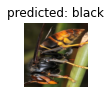

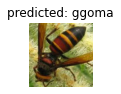

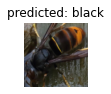

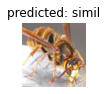

tensor([2, 1, 5, 5], device='cuda:0')


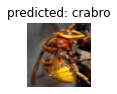

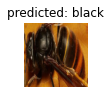

In [8]:
print(class_names)


visualize_model(model_ft)

In [16]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:
was_training = model_ft.training
model_ft.eval()

import cv2


# img_dir = 'C:\\Users\\CILAB\\Documents\\github\\anu_ci\\resnet\\data\\vespa\\train\\apis\\apis1222.jpg'

img_dir = 'C:\\Users\\CILAB\\Documents\\github\\anu_ci\\resnet\\data\\vespa\\train\\black\\black0701.jpg'

'''
with torch.no_grad():
    image = cv2.imread(img_dir)
    image = cv2.resize(image, dsize=(224, 224),interpolation=cv2.INTER_LINEAR)
    #image_swap = np.swapaxes(image, 0,2)
    #image_swap = np.expand_dims(image_swap, axis=0)



    print(image.shape)


    tensor_ = torch.from_numpy(image).unsqueeze(0)
    tensor = tensor.float()
    #tensor_ = tensor_.to(device)


    outputs = model_ft(tensor_)

    print(outputs)

    _, preds = torch.max(outputs, 1)

    print(preds)
'''


'\nwith torch.no_grad():\n    image = cv2.imread(img_dir)\n    image = cv2.resize(image, dsize=(224, 224),interpolation=cv2.INTER_LINEAR)\n    #image_swap = np.swapaxes(image, 0,2)\n    #image_swap = np.expand_dims(image_swap, axis=0)\n\n\n\n    print(image.shape)\n\n\n    tensor_ = torch.from_numpy(image).unsqueeze(0)\n    tensor = tensor.float()\n    #tensor_ = tensor_.to(device)\n\n\n    outputs = model_ft(tensor_)\n\n    print(outputs)\n\n    _, preds = torch.max(outputs, 1)\n\n    print(preds)\n'

In [11]:
def visualize_model2(model, img_dir):
    was_training = model.training
    model.eval()

    fig = plt.figure()

    with torch.no_grad():
        image = np.array(cv2.imread(img_dir))
        image = cv2.resize(image, dsize=(224, 224))
        image = np.swapaxes(image, 0,2)
        #image = np.expand_dims(image_swap, axis=0)
        
        #image = torch.from_numpy(image).type(torch.FloatTensor)
        
        image = tensor_.to(device)
        
        # image = torch.from_numpy(image).unsqueeze(0)
        
        image = image.float()
        
        outputs = model_ft(image)
        print(outputs)
        
        _, preds = torch.max(outputs, 1)
        
        print(preds)

        model.train(mode=was_training)

In [15]:
visualize_model2(model_ft, img_dir)

NameError: name 'tensor_' is not defined

<Figure size 432x288 with 0 Axes>

In [28]:


torch.save(model_ft, "epoch300.pth")

In [29]:
device = torch.device("cuda")
model = torch.load("epoch300.pth")
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

tensor([2, 5, 4, 3], device='cuda:0')


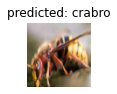

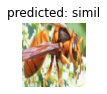

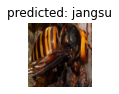

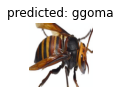

tensor([4, 0, 5, 1], device='cuda:0')


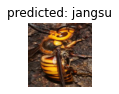

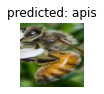

In [30]:
# visualize_model(model.cuda())

visualize_model(model.cuda())